In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Embedding, Conv1D, BatchNormalization, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from dataUtils import DataUtils
from model_utils import ModelUtils

C:\Users\Yang\.conda\envs\test_speedcom\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
dset = DataUtils.readData('temp_cleaned_data.tsv', sep='\t')

   #      Name      name_smiles  Wavelength  Epsilon  Quantum Yield
0  1   Benzene      C1=CC=CC=C1      254.75      210          0.053
1  2   Toluene     CC1=CC=CC=C1      261.75     2860          0.170
2  3  o-Xylene    CC1=CC=CC=C1C      263.00      254          0.170
3  4  m-Xylene  CC1=CC(=CC=C1)C      265.00      284          0.130
4  5  p-Xylene  CC1=CC=C(C=C1)C      275.00      770          0.220


In [3]:
X, y = DataUtils.get_xy(dset, 2, 3)

In [4]:
word_map = DataUtils.get_wordmap(x_smiles=X)

In [5]:
uniform_length = DataUtils.get_max_len(X) + 5

In [6]:
X_numeric = DataUtils.numeric_encoding(x_list=X, word_map=word_map, uniform_length=uniform_length)

In [7]:
X_train, X_test, y_train, y_test = DataUtils.splitData(x=X_numeric, y=y, ratio=0.2)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(213, 279)
(54, 279)
(213, 1)
(54, 1)


In [8]:
model = Sequential()
model.add(Embedding(len(word_map), 50, input_length=279))
model.add(Conv1D(192,10,activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(192,5,activation='relu'))
model.add(Conv1D(192,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 279, 50)           2250      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 270, 192)          96192     
_________________________________________________________________
batch_normalization_1 (Batch (None, 270, 192)          768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 266, 192)          184512    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 264, 192)          110784    
_________________________________________________________________
flatten_1 (Flatten)  

In [9]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [10]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

In [11]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=150, validation_data=(X_test,y_test))

Instructions for updating:
Use tf.cast instead.
Train on 213 samples, validate on 54 samples
Epoch 1/150
213/213 [==============================] - 4s 20ms/step - loss: 159812.6114 - coeff_determination: -6.1621 - lr: 2.5000e-04 - val_loss: 130658.6172 - val_coeff_determination: -7.2533 - val_lr: 2.5000e-04
Epoch 2/150
213/213 [==============================] - 3s 14ms/step - loss: 153832.4275 - coeff_determination: -5.8484 - lr: 2.5000e-04 - val_loss: 114425.7969 - val_coeff_determination: -6.2280 - val_lr: 2.5000e-04
Epoch 3/150
213/213 [==============================] - 3s 14ms/step - loss: 139081.0855 - coeff_determination: -5.2161 - lr: 2.5000e-04 - val_loss: 84068.0391 - val_coeff_determination: -4.3103 - val_lr: 2.5000e-04
Epoch 4/150
213/213 [==============================] - 3s 14ms/step - loss: 111254.9998 - coeff_determination: -3.9441 - lr: 2.5000e-04 - val_loss: 40271.6250 - val_coeff_determination: -1.5438 - val_lr: 2.5000e-04
Epoch 5/150
213/213 [========================

Epoch 38/150
213/213 [==============================] - 3s 16ms/step - loss: 12948.4158 - coeff_determination: 0.4252 - lr: 2.5000e-04 - val_loss: 12264.6553 - val_coeff_determination: 0.2253 - val_lr: 2.5000e-04
Epoch 39/150
213/213 [==============================] - 3s 15ms/step - loss: 10290.9027 - coeff_determination: 0.5421 - lr: 2.5000e-04 - val_loss: 13653.8037 - val_coeff_determination: 0.1375 - val_lr: 2.5000e-04
Epoch 40/150
213/213 [==============================] - 3s 15ms/step - loss: 11052.3108 - coeff_determination: 0.4976 - lr: 2.5000e-04 - val_loss: 15131.3818 - val_coeff_determination: 0.0442 - val_lr: 2.5000e-04
Epoch 41/150
213/213 [==============================] - 4s 18ms/step - loss: 13076.3581 - coeff_determination: 0.4160 - lr: 2.5000e-04 - val_loss: 15429.3828 - val_coeff_determination: 0.0254 - val_lr: 2.5000e-04
Epoch 42/150
213/213 [==============================] - 4s 18ms/step - loss: 13122.8100 - coeff_determination: 0.4148 - lr: 2.5000e-04 - val_loss: 1

213/213 [==============================] - 3s 16ms/step - loss: 9299.8028 - coeff_determination: 0.5912 - lr: 2.5000e-04 - val_loss: 10001.6299 - val_coeff_determination: 0.3682 - val_lr: 2.5000e-04
Epoch 77/150
213/213 [==============================] - 3s 16ms/step - loss: 8621.7284 - coeff_determination: 0.6164 - lr: 2.5000e-04 - val_loss: 10071.6992 - val_coeff_determination: 0.3638 - val_lr: 2.5000e-04
Epoch 78/150
213/213 [==============================] - 3s 16ms/step - loss: 8259.7825 - coeff_determination: 0.6269 - lr: 2.5000e-04 - val_loss: 11078.7852 - val_coeff_determination: 0.3002 - val_lr: 2.5000e-04
Epoch 79/150
213/213 [==============================] - 3s 16ms/step - loss: 7066.8070 - coeff_determination: 0.6666 - lr: 2.5000e-04 - val_loss: 10978.9072 - val_coeff_determination: 0.3065 - val_lr: 2.5000e-04
Epoch 80/150
213/213 [==============================] - 3s 15ms/step - loss: 8304.6861 - coeff_determination: 0.6308 - lr: 2.5000e-04 - val_loss: 10490.3105 - val_co

Epoch 115/150
213/213 [==============================] - 3s 15ms/step - loss: 6653.9232 - coeff_determination: 0.7051 - lr: 2.5000e-04 - val_loss: 9167.7891 - val_coeff_determination: 0.4209 - val_lr: 2.5000e-04
Epoch 116/150
213/213 [==============================] - 3s 15ms/step - loss: 5585.0134 - coeff_determination: 0.7499 - lr: 2.5000e-04 - val_loss: 10609.5605 - val_coeff_determination: 0.3298 - val_lr: 2.5000e-04
Epoch 117/150
213/213 [==============================] - 3s 16ms/step - loss: 6397.8893 - coeff_determination: 0.7063 - lr: 2.5000e-04 - val_loss: 10205.2334 - val_coeff_determination: 0.3554 - val_lr: 2.5000e-04
Epoch 118/150
213/213 [==============================] - 3s 15ms/step - loss: 5743.5585 - coeff_determination: 0.7422 - lr: 2.5000e-04 - val_loss: 9343.8926 - val_coeff_determination: 0.4098 - val_lr: 2.5000e-04
Epoch 119/150
213/213 [==============================] - 3s 15ms/step - loss: 5856.7405 - coeff_determination: 0.7395 - lr: 2.5000e-04 - val_loss: 100

In [16]:
X_test.shape

(54, 279)

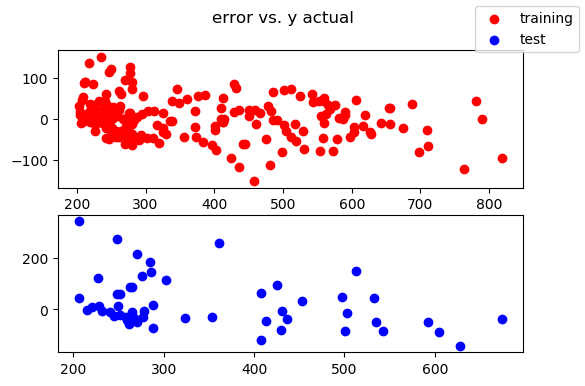

In [17]:
ModelUtils.plot_model(X_train,X_test,y_train.reshape(1,-1), y_test.reshape(1,-1),model)

In [18]:
from sklearn import metrics

###  R square training vs. R square testing

In [19]:
metrics.r2_score(y_train, model.predict(X_train))

0.8976250635080142

In [22]:
metrics.r2_score(y_test, model.predict(X_test))

0.33856509353689257

Overfitting issue; epoch ~ 100 is better fit

###  mean absolute error

In [23]:
metrics.mean_absolute_error(y_train, model.predict(X_train))

36.83746250492866

In [24]:
metrics.mean_absolute_error(y_test, model.predict(X_test))

73.32424785472729

### plot history

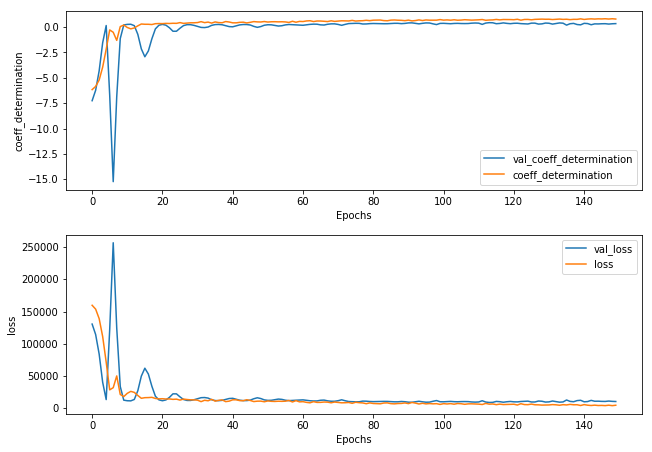

In [27]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(211)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)

In [29]:
model = Sequential()
model.add(Embedding(len(word_map), 50, input_length=279))
model.add(Conv1D(192,10,activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(192,5,activation='relu'))
model.add(Dropout(0.4))
model.add(Conv1D(192,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 279, 50)           2250      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 270, 192)          96192     
_________________________________________________________________
batch_normalization_3 (Batch (None, 270, 192)          768       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 266, 192)          184512    
_________________________________________________________________
dropout_4 (Dropout)          (None, 266, 192)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 264, 192)          110784    
_________________________________________________________________
flatten_3 (Flatten)          (None, 50688)             0         
__________

In [30]:
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [31]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

In [32]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=150, validation_data=(X_test,y_test))

Train on 213 samples, validate on 54 samples
Epoch 1/150
213/213 [==============================] - 5s 21ms/step - loss: 159704.8676 - coeff_determination: -6.1674 - lr: 2.5000e-04 - val_loss: 130825.4844 - val_coeff_determination: -7.2639 - val_lr: 2.5000e-04
Epoch 2/150
213/213 [==============================] - 3s 15ms/step - loss: 153074.3406 - coeff_determination: -5.8128 - lr: 2.5000e-04 - val_loss: 117703.9688 - val_coeff_determination: -6.4350 - val_lr: 2.5000e-04
Epoch 3/150
213/213 [==============================] - 3s 15ms/step - loss: 138774.8740 - coeff_determination: -5.3051 - lr: 2.5000e-04 - val_loss: 91618.6094 - val_coeff_determination: -4.7873 - val_lr: 2.5000e-04
Epoch 4/150
213/213 [==============================] - 3s 15ms/step - loss: 112602.2241 - coeff_determination: -4.0188 - lr: 2.5000e-04 - val_loss: 50664.7578 - val_coeff_determination: -2.2004 - val_lr: 2.5000e-04
Epoch 5/150
213/213 [==============================] - 3s 15ms/step - loss: 73032.4138 - coef

213/213 [==============================] - 3s 16ms/step - loss: 11824.2993 - coeff_determination: 0.4637 - lr: 2.5000e-04 - val_loss: 12287.1875 - val_coeff_determination: 0.2239 - val_lr: 2.5000e-04
Epoch 40/150
213/213 [==============================] - 3s 16ms/step - loss: 12555.2711 - coeff_determination: 0.4285 - lr: 2.5000e-04 - val_loss: 12870.1445 - val_coeff_determination: 0.1870 - val_lr: 2.5000e-04
Epoch 41/150
213/213 [==============================] - 4s 18ms/step - loss: 11061.2141 - coeff_determination: 0.5115 - lr: 2.5000e-04 - val_loss: 12349.3252 - val_coeff_determination: 0.2199 - val_lr: 2.5000e-04
Epoch 42/150
213/213 [==============================] - 4s 19ms/step - loss: 10026.6653 - coeff_determination: 0.5505 - lr: 2.5000e-04 - val_loss: 11969.8291 - val_coeff_determination: 0.2439 - val_lr: 2.5000e-04
Epoch 43/150
213/213 [==============================] - 4s 20ms/step - loss: 11958.3109 - coeff_determination: 0.4688 - lr: 2.5000e-04 - val_loss: 11821.3545 - v

213/213 [==============================] - 4s 17ms/step - loss: 8107.0300 - coeff_determination: 0.6288 - lr: 2.5000e-04 - val_loss: 10842.3242 - val_coeff_determination: 0.3151 - val_lr: 2.5000e-04
Epoch 78/150
213/213 [==============================] - 3s 16ms/step - loss: 7840.9399 - coeff_determination: 0.6418 - lr: 2.5000e-04 - val_loss: 10879.3623 - val_coeff_determination: 0.3128 - val_lr: 2.5000e-04
Epoch 79/150
213/213 [==============================] - 3s 16ms/step - loss: 9458.6269 - coeff_determination: 0.5724 - lr: 2.5000e-04 - val_loss: 10690.3691 - val_coeff_determination: 0.3247 - val_lr: 2.5000e-04
Epoch 80/150
213/213 [==============================] - 3s 16ms/step - loss: 9324.7587 - coeff_determination: 0.5807 - lr: 2.5000e-04 - val_loss: 10677.5020 - val_coeff_determination: 0.3255 - val_lr: 2.5000e-04
Epoch 81/150
213/213 [==============================] - 3s 16ms/step - loss: 9209.2389 - coeff_determination: 0.5897 - lr: 2.5000e-04 - val_loss: 10734.9951 - val_co

Epoch 116/150
213/213 [==============================] - 4s 17ms/step - loss: 6439.7815 - coeff_determination: 0.6998 - lr: 2.5000e-04 - val_loss: 10437.8809 - val_coeff_determination: 0.3407 - val_lr: 2.5000e-04
Epoch 117/150
213/213 [==============================] - 4s 17ms/step - loss: 5088.1823 - coeff_determination: 0.7739 - lr: 2.5000e-04 - val_loss: 10860.4336 - val_coeff_determination: 0.3140 - val_lr: 2.5000e-04
Epoch 118/150
213/213 [==============================] - 4s 17ms/step - loss: 5678.0548 - coeff_determination: 0.7430 - lr: 2.5000e-04 - val_loss: 10875.8809 - val_coeff_determination: 0.3130 - val_lr: 2.5000e-04
Epoch 119/150
213/213 [==============================] - 4s 17ms/step - loss: 5880.8377 - coeff_determination: 0.7379 - lr: 2.5000e-04 - val_loss: 10709.2939 - val_coeff_determination: 0.3235 - val_lr: 2.5000e-04
Epoch 120/150
213/213 [==============================] - 4s 17ms/step - loss: 5888.2893 - coeff_determination: 0.7351 - lr: 2.5000e-04 - val_loss: 1

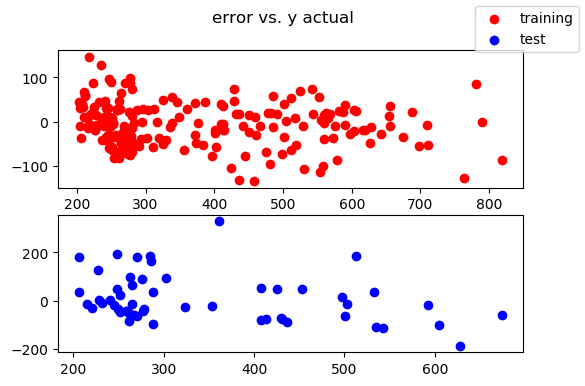

In [33]:
ModelUtils.plot_model(X_train,X_test,y_train.reshape(1,-1), y_test.reshape(1,-1),model)

In [34]:
metrics.r2_score(y_train, model.predict(X_train))

0.8953451941097397

In [35]:
metrics.r2_score(y_test, model.predict(X_test))

0.3985586617101583

In [36]:
metrics.mean_absolute_error(y_train, model.predict(X_train))

38.502615041240276

In [37]:
metrics.mean_absolute_error(y_test, model.predict(X_test))

74.48989133481626

C:\Users\Yang\.conda\envs\test_speedcom\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


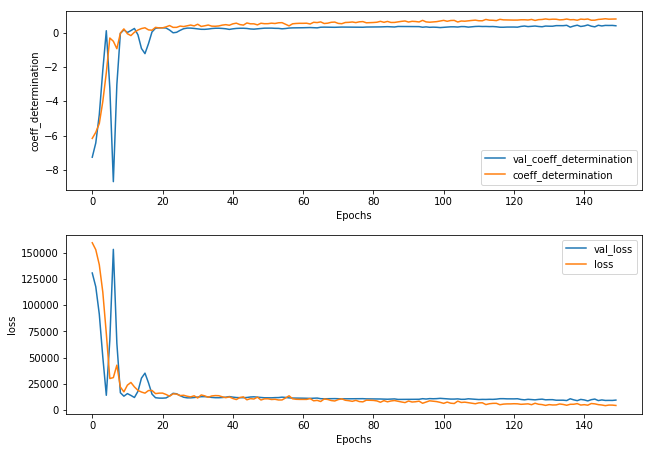

In [38]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(211)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)